This notebook develops a word2vec embedding model from scratch in Keras using the text for Alice in Wonderland (though you can run it on any book in the Gutenberg Press). It is based on the very helpful github repo found here:

https://github.com/nzw0301/keras-examples.

I found this to be a useful explainer for this technique:  

https://jalammar.github.io/illustrated-word2vec/

Here I implement the "skipgram" approach to fitting word embeddings, explained toward the end of the above blog post! Conceptually we imagine a model that takes two words (each coded as a one-hot vector over the vocabulary) as input. Each word projects to n linear hidden units. A single output unit computes the dot-product between these (proportional to cosine of the angle between them) and takes this as net input to a sigmoid unit. When the two vectors are very similar, the dot-product is high and positive and the sigmoid will output a value near 1. When the two vectors are orthogonal, the dot product is zero and the sigmoid will output a value near 0.5. When they are pointing in opposite directions, the dot product is negative and the sigmoid will output a value near 0. Here is a picture:

  ![skipgram model as a neural network](./word2vec.png)

We train the model with samples from the corpus as follows. From a snippet of text--say, a single line of the document--we choose a word to be the input word, then choose a second word to be the comparison or "context" word. If the context word is found near the target word in the snippet, we give the model a target of 1--that is, "make the cosine between these two vectors more positive." If the comparison word is not near the target word in the snippet, we assign a target of zero, ie "make the cosine between these two vectors more negative." What counts as "near" is a free parameterthat we specify, which indicates the total width of the "window" around the target word. A window that extends two words before and two words after the target creates a total window width of 5, for example. In sum, the model tries to make the embedding vectors for words that often occur within the same window more similar to one another, while make those that do not occur within the same window more distinct.

I find it useful to think of the input for the target and context words as each being encoded with a 1-hot vector with a length the total size of the vocabulary. This is, however, pretty wasteful computationally. For a vocabulary size of 3534 in the Alice text, you need a vector with 3534 elements, all of which have zero values except for one---so your are setting aside a lot of essentially unused memory. Keras handles this through use of an "Embedding" type layer. Instead of implementing the full one-hot input, we use a single input unit for each word (target and context). The unit takes integer-type input, and projects to an "Embedding" layer which specifies the total size of the vocabulary V and the dimension of the embedding space D (ie, the number of hidden units). Keras will then create a VxD weight matrix that maps from input word to hidden representation. It will interpret the integer coded by the single input unit as indicating which word is present, or equivalently which row of the weight matrix should be used to generate the activation vector over hidden units. So if we give the model 1,234 as an input value, the embedding layer will assume that word number 1,234 is present in the input and will generate activity over hidden units based on weights coded in row 1,234 of the weight matrix. The same procedures are followed for the target word and context word. The values in this weight matrix--and hence the wmbedding generated by a given word--are changed with learning to reduce error at the input, that is, to make two vectors within a window more similar and two vectors not within a window more dissimilar.

## Imports


In [1]:
import numpy as np
np.random.seed(13)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


## Get data

Let's grab a book from the Gutenberg Project. You can look up their public domain books here:

https://www.gutenberg.org

Once you have the URL to a text file of a book you can download it using the get_file function from keras, opening the specified path, and running the readlines method. This will break the file down into a list in which each element is a line from the file. Here is an example using Alice in Wonderland:

In [2]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path).readlines()

You can check out the _corpus_ object:

In [3]:
len(corpus)

3761

It's 3761 lines long! Let's look at an arbitrary element of this list:

In [4]:
corpus[1426]

'“Here! you may nurse it a bit, if you like!” the Duchess said to Alice,\n'

It's a line from the book.

We want to look across all lines of the book, drop punctuation, put everything into lower case, extract all space-separated strings, get a set of unique words,assign each word a unique integer value, and maybe get some basic statistics like word counts etc. Whew! Sounds like a lot of work. But, all the work has been done for you in Keras preprocessing functions imported above in the Tokenizer.

In [5]:
alicetokens = Tokenizer(filters='!\“#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
alicetokens.fit_on_texts(corpus)

This creates an instance of the Tokenizer class called _alicetokens_ and "fits" it to the data in the corpus we just downloaded. The _alicetokens_ object contains several data structures computed from the corpus, including:

- _word_\__counts_: ordered dictionary of unique words and their counts
- _word_\__index_: dictionary indicating the integer assigned to each word
- _word_\__docs_: number of documents in which a word appears; 'document' here is a line in the book

So you can see, for instance, how often the word "rabbit" appears by looking in the corresponding dictionary:

In [6]:
alicetokens.word_counts.get('rabbit')

49

You can see how many unique items are in the corpus by just looking at the length of the word_index dictionary. Let's set this to the vocabulary size V, adding 1 b/c Python starts counting at 0.

In [9]:
V = len(alicetokens.word_index) + 1
V

3321

The Tokenizer class also includes several methods for operating on the tokenized data; we will use one of these in a moment. (Of course, check out the Keras Tokenizer documentation for more info).

## Build model

This block will build a skipgram-type model for learning word2vec-like embeddings, based on the description provided at the beginning of the notebook. Here is what all that looks like in Keras code:



In [10]:
embed_dim = 128 #Dimensionality of the embedding space, ie, number of hidden units in model.

#input for focus word
word_in = Input(shape = (1,), dtype = 'int32') #Single input unit that takes an integer value, the word token number
word_emb = Embedding(V, embed_dim)(word_in) #Project to embedding layer expecting V words in embed_dim dimensions

#input for context word, exactly the same
cont_in = Input(shape=(1,), dtype = 'int32')
cont_emb = Embedding(V, embed_dim)(cont_in)

#output: single unit that computes dot product of two vectors then passes these as input to a sigmoid
out = Dot(axes = 2)([word_emb, cont_emb]) #Takes cosine of two embeddings
out = Reshape((1,), input_shape=(1,1))(out) #There is only one output so reshape to 1D tensor
out = Activation('sigmoid')(out) #Pass cosine to sigmoid activation function

#Make model
SkipGram = Model(inputs = [word_in, cont_in], outputs = out)
SkipGram.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       425088      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       425088      input_2[0][0]                    
______________________________________________________________________________________________

In [18]:
#Compile model
SkipGram.compile(loss='binary_crossentropy', optimizer = 'adam')

## Training the model

Recall that the corpus object is just a list of strings, with one element per line of the original text. To train the model we need to break this down into a bunch of input/output pairs that either _are_ within the specified window (_positive_ examples) or _are not_ in that window (negative examples). This seems like a lot of complicated coding! But again it is handled by Keras, using the skipgram function imported earlier.

Let's see how this works with a single line of text from the corpus.

In [141]:
d = corpus[2534]
d

'“What a curious plan!” exclaimed Alice.\n'

The _text_\__to_\__sequences_ method of the Tokenizer class takes a 'document' like this line and returns a sequence of integers indicating the indices of the words appearing in the sentence. The method takes a list as an argument, with each element containing a string of words separated by spaces (like a line in the corpus). It then returns a list of lists, with each element containing the list of word indices in the corresponding string. For the above line of the corpus:

In [142]:
alicetokens.texts_to_sequences([d])

[[31, 5, 229, 879, 2, 662, 13]]

Hey, which word is number 31? We can look it up in the Tokenzer index_word dictionary (using the dictionary _get_ method):

In [143]:
alicetokens.index_word.get(31)

'what'

So it seems to work--'what' is word 31, the first word in the sentence and the first number in the sequence. How do we get from such a sequence to the input and output patterns needed to fit the model? That is what the _skipgram_ function is for. Let's look at it for this one sentence.

In [144]:
t2s = alicetokens.texts_to_sequences([d]) #Get sequence of word indices 

#Compute skipgram input/output patterns for window-size 5, with 5 negative samples.
x, y = skipgrams(t2s[0], vocabulary_size=V, window_size=5, negative_samples=1.) 

#Skipgram returns two lists: the two words being compared (x) and the target value (y)
print('first input pair:', x[10], 'first label:', y[10])

first input pair: [879, 683] first label: 0


What are those two words? We can look them up in the tokenizer dictionary using list completion:

In [145]:
[alicetokens.index_word.get(w) for w in x[10]]

['plan', 'passed']

Note that _skipgram_ is stochastic--the particular negative-example words chosen will vary randomly from run to run, so you may get a different result than I did here. Regardless, the first word shown is the _focus_ word, which should be one of the words in our sentence--I got _plan_. The second word is the context word selected for this training example. If the context word is not near the target word (within a window of 5) in our sentence, the label shown above should be 0. I got _passed_, which is not within 5 words of _plan_ so it is a _negative_ example and the target is a 0. Let's look at another item:

In [155]:
print('first input pair:', x[5], 'first label:', y[5])
print([alicetokens.index_word.get(w) for w in x[5]])

first input pair: [31, 879] first label: 1
['what', 'plan']


Here I got _what_ and _curious_, which are within the proximity window and so got a label of 1. (Again, your results may differ as to which elements of x contain positive examples and which contain negative examples).

With this basic understanding, here is a simple loop that (a) computes the skipgram input/output patterns for each sentence in the document, (b) converts these to numpy arrays so they can be used as input and target values for the network and (c) updates the model weights based on the skipgram inputs and targets. The look runs through the entire corpus _nepochs_ times, updating the weights with each sentence, and reporting the total error at the end of each epoch.

In [161]:
nepochs = 20 #Number of passes through entire corpus

for _ in range(nepochs):
    loss = 0. #Reset loss at start of each epoch; this is just for purposes of reporting training progress!
    
    #Loop through each element of the corpus, ie each sentence:
    for i, doc in enumerate(alicetokens.texts_to_sequences(corpus)):
        #Note: enumerate returns both the sentence index number (as i) and the sentence (as doc)
        
        #Pull out input and output patterns from current sentence
        data, labels = skipgrams(sequence = doc, vocabulary_size=V, window_size=5, negative_samples=5.)
        x = [np.array(x) for x in zip(*data)] #Convert input list to a numpy array
        y = np.array(labels, dtype=np.int32)  #Convert output labels to a numpy array

        if x: #only update if there is an actual value in the input!
            loss += SkipGram.train_on_batch(x,y) #adjust weights and increment loss
    print(loss) #Report loss at end of epoch
    

462.57991685019806
457.33636757411296
449.3849313149112
440.0714026608621
433.8878654897271
427.6665825541131
424.1815341266047
420.0525850546546
414.1879755089176
410.5939049377921
410.8340151522716
401.677920546339
403.39766566045
401.1188887486933
398.2246817338164
397.8673580540635
394.6952809464419
394.20182504463446
391.53176652485126
392.2075973079045


Since the embedding layer is just linear units receiving weights from an (essentially) one-hot input code, the weight matrix from target-word input to the first embedding constitute the actual embedding. You can extract it by just grabbing the weight tensor and converting it to a numpy array:

In [162]:
wvecs  = np.array(SkipGram.weights[0])
wvecs.shape

(3321, 128)

This matrix has one row per word, ordered by word index, and the 128 values in the row are the 128-D embedding for the word.

## Looking at the vectors

How do we know if these vectors are any good? The cosine similarity between any two points in the embedding--that is, between two rows of the matrix--should capture the degree to which the two words are semantically related. So we can compute the cosine similarity between all pairs of rows to get a dissimilarity matrix. The _scikitlearn_ library has functions of this kind. Of course computing these for the full matrix would produce a pretty large matrix (3321 x 3321). We could instead compute it for a more reasonable list of words.

In [77]:
#Some imports for computing distances and visualizing data
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine


#Data reduction and visualization
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

To see if we are getting something reasonable I will choose four "animate" nouns and four inanimate nouns, extract their vectors, and compute pairwise distances between them. 

In [163]:
#Here is a set of words:
wset = ['queen', 'duchess', 'dormouse', 'hatter', 'saucer', 'drink', 'bottle', 'cup']

#Use list expansion to get the associated token numbers:
wind = np.array([alicetokens.word_index.get(w) for w in wset])

#Compute cosine similarities for all pairs of these 8 words
cdist = pairwise_distances(wvecs[wind,:], metric=cosine)

_cdist_ should now contain an 8x8 matrix, with each entry equal to the cosine distance (1 - cosine of the angle between vectors) in the 128D space. We can visualize the distance matrix as a heat plot; rows and columns will be ordered as indicated in the wset list above. I find it more intuitive to visualize _cosine similarity_ (high numbers indicate similar vectors) so I will plot 1 - cdist.

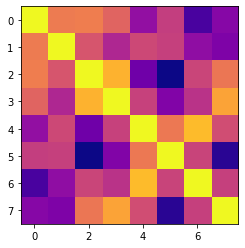

In [166]:
plt.imshow(1 - cdist, cmap='plasma', vmax = 0.4)

Here hot colors show things that are similar, and rows and columns are ordered as specified by the set of words created above. The first four words all refer to animate things--you can see they make a block in the upper left, with the four inanimate things making a block in the lower right. So the cosine distances for this subset of items seems reasonable.

Another way to visualize is to compute a low-dimesnional embedding of the 128D space, for instance using classical multidimensional scaling of the cosine matrix. The skikitlearn implementation of MDS assumes a _dissimilarity_ matrix (high positive numbers indicate things that are 

In [167]:
md2d = MDS(n_components=2, dissimilarity='precomputed') #Instance of MDS class
w2d = md2d.fit_transform(cdist) #Fit the MDS to cdist data and return 2D coordinates for each item

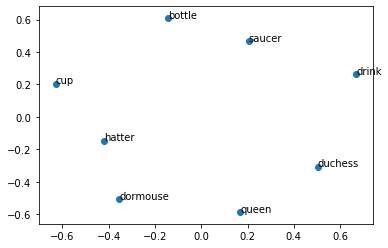

In [168]:
#Now plot the words in a 2D space with labels.
fig, ax = plt.subplots() #Initialize plot
ax.scatter(w2d[:,0], w2d[:,1]) #Add scatterplot of points from 2d coordinates
for i, l in enumerate(wset):   #Annotate each point with word labels
    ax.annotate(l, (w2d[i,0], w2d[i,1]))

You can see the living/nonliving split nicely, and that the duchess and the queen seem similar.

What if we try to visualize a larger, random sampling of words in a 2D space?

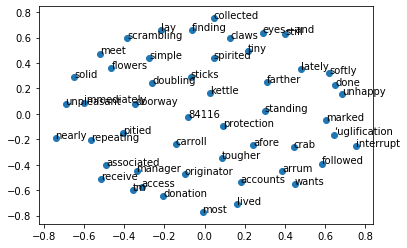

In [171]:
n = 50 #Number of words to select
s = np.random.choice(V, n, replace = False) #Get n random indices
wrand = wvecs[s, :] #Pull out the vectors for just these words
wset = [alicetokens.index_word.get(w) for w in s] #What words did we pick?
wdist  = pairwise_distances(wrand, metric = cosine) #Cosine distances between all pairs
w2d = md2d.fit_transform(wdist) #Compute MDS coordinates for these words

#Now plot the words in a 2D space with labels.
fig, ax = plt.subplots() #Initialize plot
ax.scatter(w2d[:,0], w2d[:,1]) #Add scatterplot of points from 2d coordinates
for i, l in enumerate(wset):   #Annotate each point with word labels
    ax.annotate(l, (w2d[i,0], w2d[i,1]))

Looks pretty random! Maybe it is because we are trying to reduce 128 dimensions to 2? What if we write a function to return the most similar word to any chosen word?

In [133]:
def get_closest(word, wv = wvecs, tk = alicetokens):
    vind = tk.word_index.get(word)
    nw = len(alicetokens.word_index) #number of words
    v = wv[vind,:] #target vector
    cds = [cosine(v, wv[w,:]) for w in range(nw)] #cosine dist to all words
    cds = np.array(cds) #convert to numpy array
    cds[vind] = 10 #Replace similarity to self with high value
    closest = tk.index_word.get(np.argmin(cds))
    print("The closest word to", word, "is", closest)
    return (word, closest)

In [172]:
get_closest('dormouse')


The closest word to dormouse is shook


('dormouse', 'shook')

Hm, still looks pretty random! Fitting word embeddings with a small text like this may not give the best results. Why not try adapting the code above to find vectors from a larger corpus of text?